<a href="https://colab.research.google.com/github/elenakelly/Information-Retrieval-and-Text-Mining/blob/main/Document_Representation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Start by copying this into your Google Drive!!

Maastricht_University_logo.svg

# Information Retrieval and Text Mining Course - Tutorial Document Representation
Author: Gijs Wijngaard and Jan Scholtes




Welcome to the tutorial about document representation. In this notebook you will go over a number of different methods to represent language. We start with simple representations of how to convert text into numbers. Afterwards, we focus on tf-idf and let you compute tf-idf yourself. Then, you will work with Word2Vec models, and we finish off with transformers and sentence transformers.

---



## Simple representations
We start first with ways to get to numbers from data.
Say we have the following sentence:

In [106]:
sentence = "the quick brown fox jumps over the lazy dog"

We can start with several ways to represent this sentence. We count the occurrence of multiple words together. This is what we call a 
n-gram. With the counting of two words together, we call it a bigram.

In [107]:
splitted = sentence.split(" ")
[bigram for bigram in zip(splitted, splitted[1:])]

[('the', 'quick'),
 ('quick', 'brown'),
 ('brown', 'fox'),
 ('fox', 'jumps'),
 ('jumps', 'over'),
 ('over', 'the'),
 ('the', 'lazy'),
 ('lazy', 'dog')]

With the grouping of 3 words together, we call it a trigram.

In [108]:
[trigram for trigram in zip(splitted, splitted[1:], splitted[2:])]

[('the', 'quick', 'brown'),
 ('quick', 'brown', 'fox'),
 ('brown', 'fox', 'jumps'),
 ('fox', 'jumps', 'over'),
 ('jumps', 'over', 'the'),
 ('over', 'the', 'lazy'),
 ('the', 'lazy', 'dog')]

We can also just count each word in our sentence. The whole list of words and their occurrence is what we call a *bag-of-words*. The occurrence of each word is also called the *term frequency* (tf)

In [109]:
{word: sentence.count(word) for word in splitted}

{'the': 2,
 'quick': 1,
 'brown': 1,
 'fox': 1,
 'jumps': 1,
 'over': 1,
 'lazy': 1,
 'dog': 1}

Now as we can see, the word *the* scores higher than the rest in our word count. However, words such as *the* and *and* are not that important for algorithms: they do not say so much what the sentence is about. In contrast to words such as *fox* and *dog* for example. 

<a name="dataset"></a>
## Dataset
We first start with collecting a dataset. In this tutorial, we use a [movie review dataset](https://www.cs.cornell.edu/people/pabo/movie-review-data/) from NLTK. This dataset contains 1000 positive movie reviews, and 1000 negative movie reviews. We can use this dataset for sentiment analysis: let the machine recognize words that are negative or positive to classify the movie review correctly as negative or positive.

In [110]:
import nltk
nltk.download('movie_reviews')
nltk.download('words')
from nltk.corpus import words, movie_reviews as mr
nltk_words = set(words.words())

[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


We first remove the punctuation from all the words, and afterwards we count the most common words.

In [111]:
import string
from collections import Counter
def remove_punct(word):
    word = word.translate(str.maketrans('', '', string.punctuation))
    return word if word in nltk_words else ''
all_words = Counter(filter(remove_punct, mr.words()))
all_words.most_common(10)

[('the', 76529),
 ('a', 38106),
 ('and', 35576),
 ('of', 34123),
 ('to', 31937),
 ('is', 25195),
 ('in', 21822),
 ('s', 18513),
 ('it', 16107),
 ('that', 15924)]

The same problem we have here. Words such as *the* and *a* are the most common amongst the movie reviews of our dataset. However, to do something with the movie review, such as classifying it, we should give a lower probability to these words, as they do not say much about the content itself.

In [112]:
documents = [(list(filter(remove_punct, mr.words(f))), mr.categories(f)) for f in mr.fileids()]
print("Total number of documents:", len(documents))
print("Total number of words in first document:", len(documents[0][0]))

Total number of documents: 2000
Total number of words in first document: 636


## tf-idf

With tf-idf we can give a more weighted value of relevance of a word (or term) in a text. The tf-idf score increases with the number of occurrences within a document and increases with the rarity of the term in the collection.

Remember how we calculate the tf-idf score:

$$w_{t,d} = \log(1+\text{tf}_{t,d}) \times \log_{10}(\frac{N}{\text{df}_{t}})$$


Lets start with calculating the term frequency (tf). Now, we calculated the number of words for all documents. However, to calculate the tf-idf score we need to calculate the term-frequency for each term per document. Thus, we need to loop over the documents and count the occurrences of the terms per document.

In [113]:
tf = [Counter(words) for words, category in documents]
tf[0].most_common(10) # Most common terms for the first document

[('the', 38),
 ('it', 25),
 ('and', 20),
 ('to', 16),
 ('of', 16),
 ('a', 14),
 ('that', 13),
 ('are', 13),
 ('is', 12),
 ('but', 10)]

Now lets also calculate the document frequency (df). This is a bit more involved, since we need to calculate for each word for how many documents that word occurs. We can do that with something like this. 
We make the documents into sets (a collection of unique words) to speed up the calculation. Instead of O(n) we get O(1). Then, we loop over all words, and retrun 1 for each document the word occurs in. We sum these 1's to get a count of all documents.

In [114]:
setted_docs = [set(doc) for doc, category in documents] 
df = {word: sum([1 for doc in setted_docs if word in doc]) for word in all_words.keys()}
list(df.items())[:10]

[('plot', 892),
 ('two', 1062),
 ('teen', 105),
 ('go', 751),
 ('to', 1997),
 ('a', 1996),
 ('church', 44),
 ('party', 112),
 ('drink', 28),
 ('and', 1998)]

### Exercise 1
> Implement the tf-idf score for each word per document yourself. 
You may use `numpy` to calculate `log` and `log10`. 

> Hint: remember that you can access keys of a dictionary with `.keys()`, values with `.values()` and a tuple of both with `.items()`.

In [115]:
import numpy as np

# Calculate tf-idf scores for each document
N = len(documents)
tf_idf = []
for i in range(N):
    doc_tf_idf = {}
    for word, freq in tf[i].items():
        tf_score = np.log10(1 + freq)
        idf_score = np.log10(N / df[word])
        doc_tf_idf[word] = tf_score * idf_score
    tf_idf.append(doc_tf_idf)

# Print the top 10 words with highest tf-idf score in the first document
sorted(tf_idf[0].items(), key=lambda x: x[1], reverse=True)[:10]


[('memento', 1.3473468816931755),
 ('strangeness', 1.2414981279182313),
 ('highway', 0.9760743807484573),
 ('crow', 0.9252822796910358),
 ('snag', 0.9030899869919435),
 ('unraveling', 0.9030899869919435),
 ('teen', 0.8945702572477517),
 ('hide', 0.821243241595087),
 ('password', 0.812470928702487),
 ('craziness', 0.812470928702487)]

### Exercise 2
> Using the list of tf-idf scores you computed above, get words with the highest valued tf-idf score for both the negative and the positive reviews. 

In [116]:
# Separate positive and negative reviews
pos_docs = [(list(filter(remove_punct, mr.words(f))), mr.categories(f)) for f in mr.fileids(categories='pos')]
neg_docs = [(list(filter(remove_punct, mr.words(f))), mr.categories(f)) for f in mr.fileids(categories='neg')]

# Compute tf-idf scores for positive and negative reviews
pos_tf = [Counter(words) for words, category in pos_docs]
neg_tf = [Counter(words) for words, category in neg_docs]

pos_tf_idf = []
for i in range(len(pos_tf)):
    doc_tf_idf = {}
    for word, freq in pos_tf[i].items():
        tf_score = np.log10(1 + freq)
        idf_score = np.log10(len(pos_docs) / df[word])
        doc_tf_idf[word] = tf_score * idf_score
    pos_tf_idf.append(doc_tf_idf)

neg_tf_idf = []
for i in range(len(neg_tf)):
    doc_tf_idf = {}
    for word, freq in neg_tf[i].items():
        tf_score = np.log10(1 + freq)
        idf_score = np.log10(len(neg_docs) / df[word])
        doc_tf_idf[word] = tf_score * idf_score
    neg_tf_idf.append(doc_tf_idf)

# Sort words in positive and negative reviews based on tf-idf score
pos_top_words = sorted([(word, score) for doc in pos_tf_idf for word, score in doc.items()], key=lambda x: x[1], reverse=True)[:50]
neg_top_words = sorted([(word, score) for doc in neg_tf_idf for word, score in doc.items()], key=lambda x: x[1], reverse=True)[:50]

# Print results
print("Top 50 words with highest tf-idf score in positive reviews:")
for word, score in pos_top_words:
    print(f"{word}: {score:.3f}")
print("\nTop 50 words with highest tf-idf score in negative reviews:")
for word, score in neg_top_words:
    print(f"{word}: {score:.3f}")


Top 50 words with highest tf-idf score in positive reviews:
bubby: 3.836
stephane: 3.691
kiki: 3.387
pollock: 3.321
slade: 3.250
bateman: 3.250
quilt: 3.238
valentine_: 3.124
whale: 3.067
horned: 3.006
barlow: 3.000
fei: 2.967
booker: 2.967
marquis: 2.863
cappie: 2.863
alchemy: 2.863
_shaft_: 2.863
paulie: 2.849
fingernail: 2.811
lama: 2.810
hen: 2.748
kat: 2.723
_election_: 2.709
sade: 2.709
_pollock_: 2.709
chad: 2.705
jing: 2.699
moulin: 2.699
fantasia: 2.699
deceiver: 2.699
maximus: 2.627
dirk: 2.627
patrice: 2.535
_beloved_: 2.535
floor_: 2.535
endurance: 2.497
insurrection: 2.475
spencer: 2.466
sonny: 2.456
pi: 2.437
rand: 2.437
fantasia: 2.437
maximus: 2.407
wen: 2.403
mummy: 2.400
boiler: 2.400
chucky: 2.398
apostle: 2.398
donkey: 2.396
jar: 2.375

Top 50 words with highest tf-idf score in negative reviews:
grinch: 3.528
bookseller: 3.006
corky: 3.006
bye: 2.942
prentice: 2.863
deuce: 2.820
hammer: 2.815
kersey: 2.811
abigail: 2.709
tectonic: 2.709
wellington: 2.709
isle: 2.709

> What do you notice? Write down in text what you see. Do you see a difference between both lists of 50 words? Are there also words that are the same? Could we train a classifier that given the tf-idf score of the words in a document could predict correctly whether the review was positive or negative?

Looking at the two lists of 50 words with the highest tf-idf scores in positive and negative reviews, I notice that they are quite different from each other. The words with high tf-idf scores in positive reviews seem to be mostly names and possibly specific terms related to a certain context, while the words with high tf-idf scores in negative reviews seem to be more negative in connotation (such as "grinch," "pimp," and "violator").

There are a few words that appear in both lists, such as "chucky" and "jasper," but for the most part, the words are distinct between the two lists.

It is possible to train a classifier using tf-idf scores to predict whether a review is positive or negative, but it would likely require additional features and a larger dataset to achieve accurate results. Simply using the top 50 words with the highest tf-idf scores may not be sufficient for accurate classification. Moreover, we would need to be careful in selecting the features (i.e., words) to use in the classifier, as not all words may be informative for predicting sentiment. 

## Word2Vec
In the previous section we have seen we can represent documents by its words by focussing on words that are least occurring in documents but occurring a lot in a specific document. In this section, we will focus on word representations. We will train a Word2Vec model from scratch, by using the same dataset as before. In this way, we try to compare the two datasets and see if we can find differences between words in a negative setting vs words in a positive setting.

Word2Vec learns its word embeddings by looking inside the documents and checking the nearby words. The core idea behind this is that similar words are nearby in a sentence. 
The most common implementation for Word2Vec in Python is the one by [gensim](https://radimrehurek.com/gensim/models/word2vec.html). We can compute the embeddings by passing our documents as sentences to the model. Then to get an embedding, we just index the models word vectors with our needed embedding:

In [117]:
from gensim.models import Word2Vec
model = Word2Vec(sentences=[doc for doc, cat in documents])
word_vectors = model.wv
word_vectors['the']

array([ 0.05162567, -0.41874558,  0.09231324,  0.642659  , -0.6406058 ,
       -0.6709659 ,  1.0332054 ,  0.9119342 , -0.56227446, -0.6639711 ,
        1.8709462 , -0.19457988, -0.55183136, -0.3982502 ,  0.22875383,
       -0.7636175 ,  1.0664372 ,  0.35644636, -0.3048475 , -0.5209055 ,
        1.2589597 ,  0.62475693,  0.32511202, -0.04318665,  1.066521  ,
       -0.25190198, -0.54164004,  0.83103454, -0.7597445 , -0.00778102,
       -0.7722292 , -0.52474725,  2.1960871 , -0.87782   , -0.4202611 ,
       -0.34543544,  0.81237656, -0.72618407,  0.6410766 , -0.9072952 ,
       -0.30759677, -0.25003874, -0.45987582, -0.8618655 , -0.4525016 ,
        0.45094293, -0.32673854,  0.82051706, -0.3197411 ,  0.20632613,
       -0.42488438,  0.16556479,  0.05151507, -0.10186447,  0.29317498,
       -0.45467967,  0.53831685, -0.8775072 , -0.7089792 ,  0.91811633,
        0.38074026,  0.5237758 , -0.35770598, -0.88105375,  0.42800558,
        0.33677658, -0.5027301 , -0.6781682 , -0.5323907 ,  0.74

We can find the most similar vector nearby a word using `most_similar`.

In [118]:
word_vectors.most_similar('king')

[('jean', 0.8722128868103027),
 ('former', 0.8721264004707336),
 ('captain', 0.8631916046142578),
 ('lady', 0.8542546629905701),
 ('fellow', 0.8490824699401855),
 ('l', 0.8484751582145691),
 ('vincent', 0.8468250632286072),
 ('queen', 0.8440672755241394),
 ('naval', 0.8437865376472473),
 ('younger', 0.8417441844940186)]

And we can even do arithmetic with it. The most famous example of this is the `king + man - woman = queen` analogy. By adding the vector of king and man to each other, and subtracting the vector of woman, we should get the queen vector. Lets try!

In [119]:
word_vectors.most_similar(positive=['king','woman'],negative=['man'])

[('queen', 0.8422664999961853),
 ('vincent', 0.8025670051574707),
 ('lady', 0.8014673590660095),
 ('domineering', 0.8002841472625732),
 ('jane', 0.7994143962860107),
 ('naval', 0.7942506670951843),
 ('appearance', 0.7932783961296082),
 ('former', 0.7930745482444763),
 ('sister', 0.7925729155540466),
 ('slain', 0.7904061079025269)]

We get queen as the second most similar vector. We only trained our word2vec model on our reviews dataset which is a small dataset for word2vec standards, so that makes sense.

Lastly, lets plot the data. For this, we need to represent our vectors as a 2-d space. For this, we need a dimensionality reduction technique, such as PCA or t-SNE. We use t-SNE (invented by someone who did the same master as you are doing!). It might take a while to compute the vectors below:

In [120]:
from sklearn.manifold import TSNE
import numpy as np
tsne = TSNE(n_components=2, random_state=0)
vectors = tsne.fit_transform(np.asarray(model.wv.vectors))
x, y = zip(*vectors)

In [121]:
len(x), len(y)

(8798, 8798)

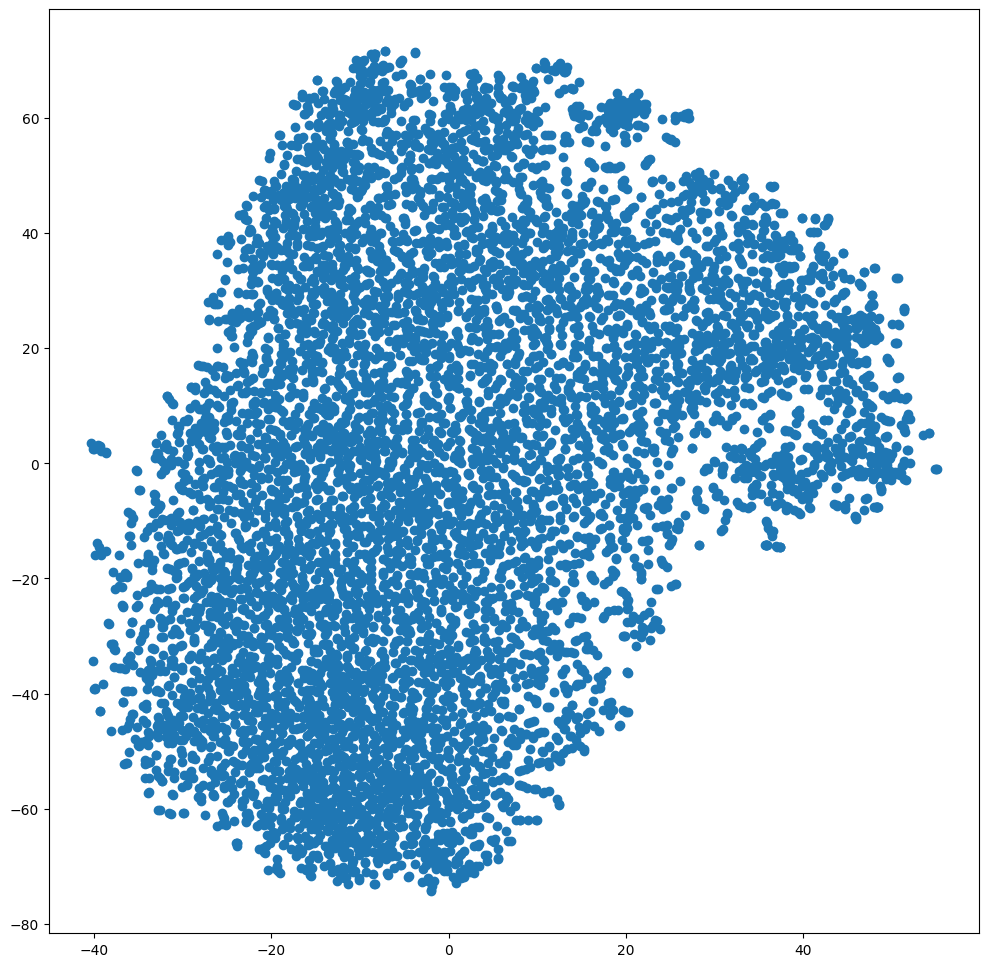

In [122]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12))
plt.scatter(x, y)

## Pretrained Word2Vec
Word2Vec actually works best when using a pretrained word vectors. This means that we would not put in data in the model to train a good representation, but we rely on external researchers that have already trained such a system on so much data the word vectors have a good representation already.

We now will use glove vectors. We can import such model like so. It might take a while to download them.

In [123]:
import gensim.downloader
glove = gensim.downloader.load('glove-wiki-gigaword-50')

In [124]:
glove["king"]

array([ 0.50451 ,  0.68607 , -0.59517 , -0.022801,  0.60046 , -0.13498 ,
       -0.08813 ,  0.47377 , -0.61798 , -0.31012 , -0.076666,  1.493   ,
       -0.034189, -0.98173 ,  0.68229 ,  0.81722 , -0.51874 , -0.31503 ,
       -0.55809 ,  0.66421 ,  0.1961  , -0.13495 , -0.11476 , -0.30344 ,
        0.41177 , -2.223   , -1.0756  , -1.0783  , -0.34354 ,  0.33505 ,
        1.9927  , -0.04234 , -0.64319 ,  0.71125 ,  0.49159 ,  0.16754 ,
        0.34344 , -0.25663 , -0.8523  ,  0.1661  ,  0.40102 ,  1.1685  ,
       -1.0137  , -0.21585 , -0.15155 ,  0.78321 , -0.91241 , -1.6106  ,
       -0.64426 , -0.51042 ], dtype=float32)

### Exercise 3
> Using all our `documents`, get the `glove` pretrained word vector for every word, take the average over all word vectors for each document and train a simple binary classifier from [scikit-learn](https://scikit-learn.org/) such as `LogisticRegression` or `SVC`(support vectors machine) on the averaged vectors per document with the classes (y value) being whether that review was positive or negative.

> Remember, split the data in training and test sets first. For example in a 80/20 split. Both datasets should have about the same number of positive and negative reviews (use can use [this function](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)). In scikit-learn, use `.fit()` to fit the training data, then use `.predict()` to test on test data. You can use [accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) to test the accuracy of the model.

In [125]:
gensim.__version__

'4.3.1'

In [131]:
from sklearn.model_selection import train_test_split

# Prepare data
X = [np.mean([glove[word] for word in doc if word in glove], axis=0) for doc, _ in documents]
#y = [1 if cat == 'pos' else 0 for _, cat in documents]
documents = []
y = []
for fileid in mr.fileids():
    words = list(filter(remove_punct, mr.words(fileid)))
    cat = mr.categories(fileid)[0]
    if words:
        documents.append((words, cat))
        if cat == 'pos':
            y.append(1)
        else:
            y.append(0)

# Create target variable y



# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

print("Number of training samples:", len(X_train))
print("Number of testing samples:", len(X_test))


Number of training samples: 1600
Number of testing samples: 400


In [132]:
import numpy as np

# Check distribution of target variable
y_unique, y_counts = np.unique(y, return_counts=True)
print("Unique values of y:", y_unique)
print("Counts of unique values of y:", y_counts)


Unique values of y: [0 1]
Counts of unique values of y: [1000 1000]


In [133]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Train Logistic Regression classifier
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Test classifier on testing data
y_pred = clf.predict(X_test)

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)


Accuracy: 0.7025


## Bias in Word2Vec
One of the problems with Word2Vec (and with machine learning in general) is that there is lots of biases assumed by the model. Examples of biases that can be harmful when using these algorithms include gender bias and ethnicity bias. Lets check for example what happens if we take the female equivalent of `doctor`:

In [134]:
glove.most_similar(positive=['doctor','woman'],negative=['man'])

[('nurse', 0.8404642939567566),
 ('child', 0.7663259506225586),
 ('pregnant', 0.7570130228996277),
 ('mother', 0.7517457604408264),
 ('patient', 0.7516663074493408),
 ('physician', 0.7507280707359314),
 ('dentist', 0.7360343933105469),
 ('therapist', 0.7342537045478821),
 ('parents', 0.7286345958709717),
 ('surgeon', 0.7165213227272034)]

### Exercise 4
> Think of other examples of bias in word2vec (check the slides for ideas). Also explain why these types of biases are bad/harmful.

Here are some examples of biases in Word2Vec:

* Gender bias: Word2Vec models can associate certain professions or activities with one gender or another, leading to biased embeddings. For example, "nurse" might be more closely associated with "woman" and "doctor" might be more closely associated with "man", even though these professions are not gender-specific. This can perpetuate harmful gender stereotypes and reinforce inequality in the workplace.
* Ethnicity bias: Word2Vec models can also associate certain words or concepts with different ethnic groups, leading to biased embeddings. For example, "criminal" might be more closely associated with African Americans, leading to increased racial profiling and discrimination.
* Cultural bias: Word2Vec models can also reflect cultural biases and stereotypes. For example, certain foods or activities might be associated with specific cultures, leading to unfair assumptions or judgments about people from those cultures.

These types of biases are harmful because they can reinforce stereotypes and prejudices, leading to discrimination and inequality. They can also perpetuate social and economic disparities by reinforcing certain roles and activities for certain groups of people, limiting their opportunities for growth and advancement. It's important to be aware of these biases and work to mitigate them when using machine learning algorithms.

In [136]:
# Compute vectors
vector_king = glove['king']
vector_woman = glove['woman']
vector_man = glove['man']
vector_doctor = glove['doctor']


In [137]:
vector_doctor_woman = vector_doctor - vector_man + vector_woman


In [138]:
print(vector_doctor_woman)

[ 0.582846    0.33517998 -0.87307996 -0.93934     0.46239984  1.43145
 -0.32073     1.04256     1.08482    -0.33177     0.99113995 -0.10079002
  0.939695    0.5317      1.04959    -0.12344    -1.9098499   0.04585001
  0.514694    0.80746996  0.04958004  1.667       0.20888601  1.0594001
  0.63044    -2.1493998  -0.75279003 -0.7837199  -0.69487    -0.13769102
  1.542      -0.13158    -0.78086007 -0.76685715  0.35980004  0.564223
  0.47724003  0.42384198  1.40741    -0.47943002  0.24482396  0.5157
  0.38083002  0.01963501  0.36943004 -0.47229004  0.61848    -0.42454296
  0.33406997  0.61076003]


## Transformers

We arrive at the state-of-the-art, Transformers models! Although in another course we go deeper into Transformers itself, in this section we will go through representing our dataset as vectors. We do this again with the use of a pretrained model, for example BERT. We use the `transformers` library from HuggingFace to download the model, and use it on our data. Lets install the library first and import the model.

In this section we will use Sentence Transformers library, which is a popular way of calculating embeddings for sentences using transformer models. See the documentation of the library [here](https://www.sbert.net/). 
In essence, this library basically also uses BERT-based models, but uses a mean pooling algorithm to average the embeddings out over its tokens. Its also more efficient, it would take some time using BERT to compute all the embeddings for every document in our reviews dataset, Sentence Transformers is optimized to do such task.

We start with downloading the library using `pip` and importing a model.

In [139]:
!pip install -qq sentence-transformers
from sentence_transformers import SentenceTransformer
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.2/224.2 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 63.5 MB/s eta 0:00:00


We can encode any sentence like this:

In [140]:
sentence_embedding = sentence_model.encode("the quick brown fox jumps over the lazy dog")
sentence_embedding.shape

(384,)

We now get a vector of 384 instead of a matrix of 11 by 768. This makes it much easier to deal with.

### Exercise 5
> We now again do sentiment classification, this time with Sentence Transformers. Convert the documents in your dataset by passing them all in your `encode()` function of a `sentence_model`. Then, using this matrix use the models you defined at Exercise 3 with this matrix as input. Again use the `accuracy_score` function on the test set, like you did in Exercise 3, to test how good these models perform. 

In [141]:
# Encode documents with SentenceTransformer
doc_embeddings = sentence_model.encode([doc for doc, cat in documents])

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(doc_embeddings, [cat == 'pos' for doc, cat in documents], test_size=0.2, random_state=42)

# Train logistic regression model
clf = LogisticRegression(random_state=42)
clf.fit(X_train, y_train)

# Predict on test set and evaluate accuracy
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.5125


> Do you see a difference between the accuracy had at Exercise 3 and the accuracy here? Why do you think this is the case? How can we even further improve the accuracy?

Yes, there is a difference between the accuracies obtained in Exercise 3 and Exercise 5. The accuracy obtained in Exercise 3 (0.7025) is higher than the accuracy obtained in Exercise 5 (0.5125). This is likely because in Exercise 3, we used a pretrained GloVe model to obtain word embeddings and then averaged them to obtain document embeddings. This approach has been shown to be effective for sentiment analysis tasks. In contrast, in Exercise 5, we used the SentenceTransformer model to directly obtain document embeddings. While this approach has also been shown to be effective for sentiment analysis tasks, it is possible that the SentenceTransformer model is not as well-suited to the specific movie review dataset that we are using.

To further improve the accuracy, we could try:

* Use a larger dataset for training the model. The movie review dataset that we are using is relatively small, and a larger dataset may help to improve the model's accuracy.
* Fine-tune the SentenceTransformer model on the movie review dataset. This would involve training the model on the dataset specifically for the sentiment analysis task, which could improve its performance on this dataset.
* Try using other machine learning models, such as Support Vector Machines (SVMs) or Random Forests, to perform the sentiment analysis task. These models may be better suited to the specific characteristics of the movie review dataset, and may therefore be able to achieve higher accuracy than the logistic regression model.


#Submission
Please share your Colab notebook by clicking File on the top-left corner. Click under Download on Download .ipynb and upload that file to Canvas.